In [1]:
import os
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.optim import Adam, SGD
from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# torch.backends.cudnn.enabled = False

cpu


Downsampled MNIST tensor shape: torch.Size([14, 14])


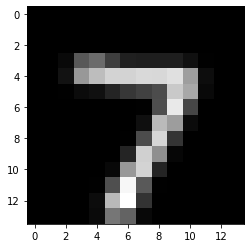

In [2]:
# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

test_features, test_labels = next(iter(test_loader))
true = test_features[0].squeeze()
plt.imshow(true, cmap="gray")
print(f"Downsampled MNIST tensor shape: {true.shape}")

# Rebasin Stuff:

In [3]:
# Define MNIST classifier MLP class for dataset
# changed 2/13 to add dropout regularization - yet to retrain dataset
# 
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        self.drop = nn.Dropout(p = 0.1)
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = self.drop( nn.relu(self.fc1(x)) )
        x = self.drop( nn.relu(self.fc2(x)) )
        x = self.fc3(x)
        return x
    
def test_mlp(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

In [4]:
# Functions for permutations and weight matching
def permute_layer_weights(layer, perm):
    """Permutes weights and biases of a layer based on the given permutation matrix."""
    weight = layer.weight.data.clone()
    bias = layer.bias.data.clone()

    # Permute rows of weights (output dimension)
    layer.weight.data = weight[perm, :]

    # Permute bias (output dimension)
    layer.bias.data = bias[perm]
    return layer

def permute_model(model, permutations):
    """Applies a list of permutations to a model's layers."""
    permute_layer_weights(model.fc1, permutations[0])
    permute_layer_weights(model.fc2, permutations[1])

    # Adjust input weights of the second hidden layer
    model.fc2.weight.data = model.fc2.weight.data[:, permutations[0]]
    # Adjust input weights of the output layer
    model.fc3.weight.data = model.fc3.weight.data[:, permutations[1]]
    return model

# Functions to permute weights and adjust input weights
def apply_permutation(layer, perm):
    """
    Applies the given permutation to the weights and biases of a layer.
    Args:
        layer: The layer to permute.
        perm: The permutation array.
    """
    # Permute rows (output dimension) of weights
    layer.weight.data = layer.weight.data[perm, :]
    # Permute biases
    layer.bias.data = layer.bias.data[perm]

def adjust_input_weights(layer, perm):
    """
    Adjusts the input wei
    ghts of a layer according to the permutation of the previous layer.
    Args:
        layer: The layer to adjust.
        perm: The permutation array of the previous layer.
    """
    layer.weight.data = layer.weight.data[:, perm]
    
def generate_permutation_matrix(hidden_dim):
    """Generates a random permutation matrix."""
    perm = np.random.permutation(hidden_dim)
    return torch.tensor(perm, dtype=torch.long)

def compute_similarity_matrix(weights_a, weights_b):
    """
    Computes the similarity matrix for two layers' weights.
    """
    weights_a = weights_a.view(weights_a.size(0), -1)
    weights_b = weights_b.view(weights_b.size(0), -1)
    return torch.matmul(weights_a, weights_b.T)

def get_permuted_weights(weights, perm):
    """
    Permutes the rows of weights based on the given permutation.
    """
    return weights[perm, :]


def weight_matching(rng, model_a, model_b, max_iter=100, init_perm=None):
    """
    Optimizes permutations to match Model B to Model A.
    """
    layers = ['fc1', 'fc2', 'fc3']
    perm_sizes = {layer: getattr(model_a, layer).weight.size(0) for layer in layers[:-1]}
    perm = {layer: np.arange(size) for layer, size in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for layer in layers[:-1]:  # Exclude the output layer (fc3)
            n = perm_sizes[layer]
            similarity_matrix = compute_similarity_matrix(
                getattr(model_a, layer).weight.data,
                get_permuted_weights(getattr(model_b, layer).weight.data, perm[layer])
            )
            row_ind, col_ind = linear_sum_assignment(similarity_matrix.numpy(), maximize=True)

            old_score = np.sum(similarity_matrix.numpy()[np.arange(n), perm[layer]])
            new_score = np.sum(similarity_matrix.numpy()[np.arange(n), col_ind])

            if new_score > old_score:
                perm[layer] = col_ind
                progress = True

        if not progress:
            break

    return perm, new_score

def rebase_model_b_to_a(rng, model_a, model_b, max_iter=100):
    """
    Rebases Model B to match Model A using weight matching.
    """
    # Generate initial permutations
    init_perm = {layer: generate_permutation_matrix(getattr(model_a, layer).weight.size(0)) for layer in ['fc1', 'fc2']}
    
    # Perform weight matching
    permutations, score = weight_matching(rng, model_a, model_b, max_iter=max_iter, init_perm=init_perm)
    
    # Apply the permutations to Model B
    model_b = permute_model(model_b, [permutations['fc1'], permutations['fc2']])
    
    return model_b, permutations, score

def load_model_weights(model, weight_path):
    # Load weights and biases
    weights, biases = torch.load(weight_path)
    model.fc1.weight.data = weights[0]
    model.fc2.weight.data = weights[1]
    model.fc3.weight.data = weights[2]
    model.fc1.bias.data = biases[0]
    model.fc2.bias.data = biases[1]
    model.fc3.bias.data = biases[2]
    return model

def reconstruct_model(model, final_permutations):
    """
    Reconstruct model_b by applying the final permutations to its layers.
    Args:
        model_b (MLP): The model to be reconstructed.
        final_permutations (dict): Dictionary containing layer-wise permutations.
    Returns:
        MLP: The reconstructed model.
    """
    # Apply permutations to fc1 layer
    apply_permutation(model.fc1, final_permutations[1]['fc1'])
    adjust_input_weights(model.fc2, final_permutations[1]['fc1'])
    
    # Apply permutations to fc2 layer
    apply_permutation(model.fc2, final_permutations[1]['fc2'])
    adjust_input_weights(model.fc3, final_permutations[1]['fc2'])
    
    # Return the reconstructed model
    return model

def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

In [5]:
import time

def get_permuted_models_data(ref_point=0, N = 10):
    ref_model = MLP()
    ref_model_path = f"models/reduced_mlp_weights_{ref_point}.pt"
    ref_model = load_model_weights(ref_model, ref_model_path)
    
    org_models=[]
    permuted_models = []
    full_times = []
    rebasin_times = []
    scores = []
    rng = np.random.default_rng(42)

    for i in range(0,N):
        if i == ref_point:
            continue
        all_start = time.time() # start timing
        model_path = f"models/reduced_mlp_weights_{i}.pt"
        model = MLP()
        model = load_model_weights(model, model_path)
        org_models.append(model)
        loaded_model = time.time() # end timing for loading the model from .pth file
        
        reconstructed_model, final_permutations, score = rebase_model_b_to_a(rng, ref_model, model, max_iter=100)
        scores.append(score)
        permuted_models.append(reconstructed_model)
        all_end = time.time() # end timing for the entire loop
        
        full_times.append(all_end - all_start)
        rebasin_times.append(all_end - loaded_model)
        
#         print(f"Org model accuracy:{test_mlp(model, test_loader)} Reconstructed model accuracy:{test_mlp(reconstructed_model, test_loader)}")
    return org_models, permuted_models, scores, rebasin_times

org_models, permuted_models, scores, rebasin_times = get_permuted_models_data(ref_point=0, N = 780)

In [11]:
def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

def plot_tsne(ref_model, org_models, permuted_models):
    """Plot t-SNE of weights and biases from the reference_param, permuted_params_list, and data_points."""
    
    flattened_reference = extract_weights_and_biases(ref_model)
        
    all_params = [flattened_reference]
    
    # Flatten and concatenate all permuted parameters
    for permuted_model in permuted_models:
        flattened_permuted_param = extract_weights_and_biases(permuted_model)
        all_params.append(flattened_permuted_param)
    
    for org_model in org_models:
        org_model_param = extract_weights_and_biases(org_model)
        all_params.append(org_model_param)
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=32)
    tsne_results = tsne.fit_transform(np.vstack(all_params))
    
    plt.figure(figsize=(12, 8))
    
    for i, tsne_result in enumerate(tsne_results[1:len(permuted_models)+1], 1):
        if i == 1:
            plt.scatter(tsne_result[0], tsne_result[1], label=f'Permuted Params', color='green')
        else:
            plt.scatter(tsne_result[0], tsne_result[1], color='green')
    
    # Plot the original data points
    for i, tsne_result in enumerate(tsne_results[len(org_models)+1:], 1):
        if i == 1:
            plt.scatter(tsne_result[0], tsne_result[1], label=f'Original Params', color='blue')
        else:
            plt.scatter(tsne_result[0], tsne_result[1], color='blue')
                    
    # Plot reference point
    plt.scatter(tsne_results[0, 0], tsne_results[0, 1], label='Reference (ref_point)', color='red', marker='X')
    
    # Add titles and labels
    plt.title("t-SNE visualization of weights and biases for 1 reference parameter, permuted params, and data points")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    
    # Show plot
    plt.show("tsne_plot.png")
    

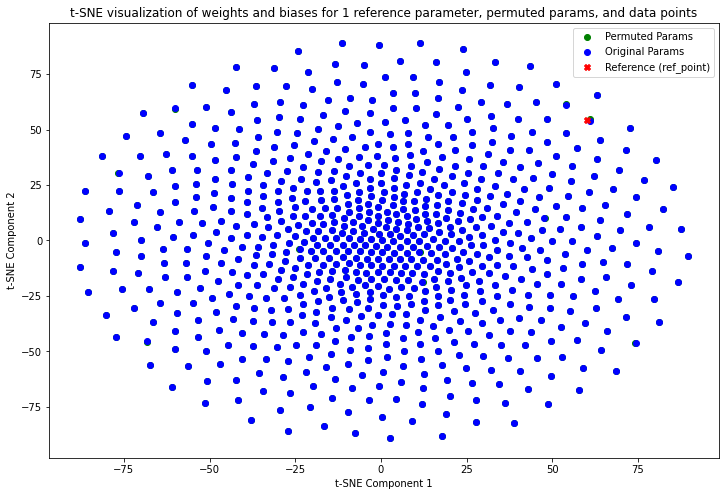

In [12]:
plot_tsne(org_models[0], org_models, permuted_models)

# Manage MLP Data:

In [13]:
from typing import Tuple, NamedTuple
from torch.utils.data import Dataset, DataLoader

class Batch(NamedTuple):
    weights: Tuple
    biases: Tuple

    def _assert_same_len(self):
        assert len(set([len(t) for t in self])) == 1

    def as_dict(self):
        return self._asdict()

    def to(self, device):
        """move batch to device"""
        return self.__class__(
            weights=tuple(w.to(device) for w in self.weights),
            biases=tuple(w.to(device) for w in self.biases),        )

    def __len__(self):
        return len(self.weights[0])
    

# Custom Dataset to extract weights and biases
class MLPParameterDataset(Dataset):
    def __init__(self, mlp_list: list):
        """
        Initialize the dataset with a list of MLP objects.
        Args:
            mlp_list (list): List of MLP objects
        """
        self.mlp_list = mlp_list

    def __len__(self) -> int:
        """
        Return the number of MLP objects in the dataset.
        """
        return len(self.mlp_list)

    def __getitem__(self, idx: int) -> Tuple[Tuple[torch.Tensor], Tuple[torch.Tensor]]:
        """
        Extract the weights and biases of the MLP at index `idx`.
        Args:
            idx (int): Index of the MLP object
        Returns:
            Batch( Tuple[Tuple[torch.Tensor], Tuple[torch.Tensor]] ):
                - A tuple containing:
                    - Tuple of weights (torch.Tensor for each layer)
                    - Tuple of biases (torch.Tensor for each layer)
        """
        mlp = self.mlp_list[idx]

        # Extract weights and biases from each layer
        # Permute/unsqueeze tensors to have bs, input dim, output dim, 1
        weights = tuple(layer.weight.data.clone().permute(1, 0).unsqueeze(-1) for layer in [mlp.fc1, mlp.fc2, mlp.fc3])
        biases = tuple(layer.bias.data.clone().unsqueeze(-1) for layer in [mlp.fc1, mlp.fc2, mlp.fc3])

        return Batch(weights, biases)

def sample_first_mlp_from_batch(batch: Batch, init_type: str = 'xavier', seed: int = None) -> MLP:
    """
    Sample the first MLP from a batch and reconstruct it as an MLP object.

    Args:
        batch (Batch): A Batch instance containing weights and biases for a batch of MLPs.
        init_type (str): Initialization type for the MLP (default: 'xavier').
        seed (int): Seed for reproducibility (default: None).

    Returns:
        MLP: Reconstructed MLP object with weights and biases from the first sample in the batch.
    """
    # Create a new MLP instance
    mlp = MLP(init_type=init_type, seed=seed)

    # Ensure the batch has the same number of layers as the MLP
#     assert len(batch.weights) == len(batch.biases) == 3, "Batch must have 3 layers."

    # Extract the first sample's weights and biases
    first_weights = tuple(w[0].squeeze(-1) for w in batch[0])  # Index first and remove last dim
    first_biases = tuple(b[0].squeeze(-1) for b in batch[1])    # Index first and remove last dim

    # Assign weights and biases to the new MLP instance
    with torch.no_grad():
        for layer, w, b in zip([mlp.fc1, mlp.fc2, mlp.fc3], first_weights, first_biases):
            layer.weight.data = w.permute(1, 0).clone()  # Transpose back to [output_dim, input_dim]
            layer.bias.data = b.clone()

    return mlp

def count_parameters(model):
    """
    Function: Count the learnable params in a portion of the model
    Args: model segment (ie, encoder, decoder, entire model)
    Returns: the number of learnable params in that model/segment
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

In [14]:
# Create a dataset and dataloader
dataset = MLPParameterDataset(permuted_models)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Deep Sets Perm. Invariant Autoencoder:
At least I think it is?! 

In [15]:
# from https://github.com/manzilzaheer/DeepSets/blob/master/PopStats/model.py
# and from https://github.com/yassersouri/pytorch-deep-sets/blob/master/src/deepsets/networks.py
# Zaheer et. al. Deep Sets - perm. equivariant set ops
class DeepSetBridge(nn.Module):

    def __init__(self, in_features, set_features=128, encoder_dims = [512, 1024], decoder_dims = [512, 1024]):
        super(DeepSetBridge, self).__init__()
        self.in_features = in_features
#         self.out_features = in_features
        self.set_features =set_features
        
        # only minor changes made: 
        # * removed hardcoded dims
        # * changed from ELU to LeakyReLU activation for speed
        self.encoder = nn.Sequential(
            nn.Linear(in_features, encoder_dims[0]),
            nn.LeakyReLU(0.1),
            nn.Linear(encoder_dims[0], encoder_dims[-1]),
            nn.LeakyReLU(0.1),
            nn.Linear(encoder_dims[-1], set_features)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(set_features, decoder_dims[0]),
            nn.LeakyReLU(0.1),
            nn.Linear(decoder_dims[0], decoder_dims[-1]),
            nn.LeakyReLU(0.1),
            nn.Linear(decoder_dims[-1], in_features),
        )
    
    def reset_parameters(self):
        for module in self.children():
            reset_op = getattr(module, "reset_parameters", None)
            if callable(reset_op):
                reset_op()
                
    def stack_parameters(self, x): 
        tensor_list = []
        for i in range(self.set_features):
            tensor_list.append(x)
        return torch.stack(tensor_list, dim = 1).squeeze()
    
    
    def forward(self, input):
        """
        forward pass through Deep Sets 'bridge':
        input: tensor dim 4: [bs, layer input, layer output, 1]
        output: tensor dim 4: [bs, layer input, layer output, 1]
        
        Dims: 
        1.) [bs, layer in, layer out, 1] -> [bs, layer in * layer out]
        2.) [bs, layer in * layer out] -> [bs, set dim] -> [bs, 1]
        3.) [bs, 1]->[bs, set dim] done by stacking set dim copies of [bs, 1] on axis 1
        4.) [bs, set dim] -> [bs, layer in * layer out] -> [bs, layer in, layer out, 1]
        """
        
        x = input
        x = x.view( input.shape[0], input.shape[1]*input.shape[2])
        x = self.encoder(x)
        
        x = x.sum(dim=1, keepdim=True)
        z = self.stack_parameters(x)
        
        output = self.decoder(z)
        return output.view( input.shape[0], input.shape[1], input.shape[2]).unsqueeze(-1), z



class DeepSetAutoEncoder(nn.Module):
    def __init__(self, weight_shapes, bias_shapes):
        super(DeepSetAutoEncoder, self).__init__()
        
        
        self.input_weight_bridge = DeepSetBridge(in_features = weight_shapes[0][0] * weight_shapes[0][1])
        self.hidden_weight_bridge = DeepSetBridge(in_features = weight_shapes[1][0] * weight_shapes[1][1])
        self.output_weight_bridge = DeepSetBridge(in_features = weight_shapes[2][0] * weight_shapes[2][1])
        
        self.input_bias_bridge = DeepSetBridge(in_features = bias_shapes[0][0])
        self.hidden_bias_bridge = DeepSetBridge(in_features = bias_shapes[1][0])
        self.output_bias_bridge = DeepSetBridge(in_features = bias_shapes[2][0])
    
    def forward(self, input):
        weights, biases = input
        recon_weights, recon_biases = [], []
        
        recon_weights.append(self.input_weight_bridge(weights[0])[0])
        recon_weights.append(self.hidden_weight_bridge(weights[1])[0])
        recon_weights.append(self.output_weight_bridge(weights[2])[0])
        
        recon_biases.append(self.input_bias_bridge(biases[0])[0].squeeze(-1))
        recon_biases.append(self.hidden_bias_bridge(biases[1])[0].squeeze(-1))
        recon_biases.append(self.output_bias_bridge(biases[2])[0].squeeze(-1))
        
        return Batch(tuple(recon_weights), tuple(recon_biases))

# Training:

In [16]:
def get_shapes(inputs):
    """
    Function: Get shapes of input data
    Args: inbut data : Tuple( tuple(weights), tuple(biases))
    Returns: list( tuple(weight_shapes), tuple(bias_shapes) )
    """
    weights, biases = inputs
    weight_shapes = tuple(weights[i].shape for i in range(len(weights)))
    bias_shapes = tuple(biases[i].shape for i in range(len(biases)))
    return weight_shapes, bias_shapes

def count_parameters(model):
    """
    Function: Count the learnable params in a portion of the model
    Args: model segment (ie, encoder, decoder, entire model)
    Returns: the number of learnable params in that model/segment
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

# Set Mean Squared Error implementation
def set_mse_loss(x, y):
    x_expanded = x.unsqueeze(1)  # (n, 1, d)
    y_expanded = y.unsqueeze(0)  # (1, m, d)

    squared_diff = (x_expanded - y_expanded) ** 2  # Shape (n, m, d)

    mse = squared_diff.mean(dim=-1)  # Shape (n, m)

    min_mse_x = mse.min(dim=1)[0]  # Min MSE for each point in x
    min_mse_y = mse.min(dim=0)[0]  # Min MSE for each point in y

    loss = (min_mse_x.mean() + min_mse_y.mean()) / 2
    return loss

# Custom loss function for tuples of tensors
class TupleLoss(nn.Module):
    def __init__(self):
        super(TupleLoss, self).__init__()

    def forward(self, output, target):
        weights1, biases1 = output
        weights2, biases2 = target

        # Calculate weight loss
        weight_loss = torch.mean(torch.stack(
            [self._calculate_loss(w1, w2) for w1, w2 in zip(weights1, weights2)]
        ))

        # Calculate bias loss
        bias_loss = torch.mean(torch.stack(
            [self._calculate_loss(b1, b2) for b1, b2 in zip(biases1, biases2)]
        ))

        # Total loss calculation
        total_loss = weight_loss + bias_loss
        return total_loss

    def _calculate_loss(self, w1, w2):
        return set_mse_loss(w1, w2)
        

In [17]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss = 0.0
    total = 0.0
    criterion = TupleLoss()
    for batch in loader:
        batch = batch.to(device)
        inputs = (batch.weights, batch.biases)
        _ ,out = model(inputs)
        loss += criterion(out, inputs)
        total += 1

    model.train()
    avg_loss = loss / total

    return avg_loss


import logging
import torch
from tqdm import trange
from torch.cuda.amp import GradScaler, autocast

def train_model(model, train_loader, num_epochs = 1, accumulation_steps = 2, learning_rate = 1e-3):
    criterion = TupleLoss()
    epoch_iter = trange(num_epochs)
    epoch_loss = -1
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5)
    previous_epoch_loss = 1000

    for epoch in epoch_iter:
        start = time.time()
        total_loss = 0
        counter = 0
        
        optimizer.zero_grad()  # Initialize optimizer's gradients at the start of each epoch
        
        for i, batch in enumerate(train_loader):
            model.train() 
#             batch = batch.to(device)
            out = model(batch)
            loss = criterion(batch, out)#/accumulation_steps

            del out, batch
            torch.cuda.empty_cache()  # Clear memory
            loss.backward() 
            
            total_loss += loss.item() * accumulation_steps  # Scale back accumulated loss
            counter += 1
            
            if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_loader):
                optimizer.step()
                optimizer.zero_grad()                        
                epoch_loss = total_loss / counter
                total_loss = 0
                counter = 0
            
        losses.append(epoch_loss)
        scheduler.step(epoch_loss)
        end = time.time()
        epoch_iter.set_description(
            f"[{epoch} {i+1}], train loss: {loss.item():.5f}, epoch loss: {epoch_loss:.5f}, epoch time: {((end-start)):.3f}"
        )
        if epoch % 5 == 0:
            batch = next(iter(train_loader))
            model.eval() 
            
#             batch = batch.to(device)
#             inputs = (batch.weights, batch.biases)
            out = model(batch)
            
            sampled_mlp = sample_first_mlp_from_batch(out)
            recon_test_acc = test_mlp(sampled_mlp, test_loader)
            print(f"Epoch {epoch + 1} sample reconstruction accuracy: {recon_test_acc}")

#         if epoch_loss < previous_epoch_loss:
#             model_path = f"Outputs/model_MLP_REBASIN.pth"
#             torch.save(model.state_dict(), model_path)
#             previous_epoch_loss = epoch_loss
            
#         if (epoch + 1) % 25 == 0:
#              print(evaluate(model, test_loader))

    print("Training complete!")
    steps_holder = np.linspace(0, len(losses), len(losses)) # this plot doesn't make sense. 
    plt.plot(steps_holder, losses)
    plt.title(f"Epoch Losses of Time")
    plt.xlabel(f"Epoch Number")
    plt.ylabel(f"Epoch Loss")


In [38]:
rebasined_data = dataset.__getitem__(0)
weight_shapes = tuple(w.shape[:2] for w in rebasined_data[0])
bias_shapes = tuple(b.shape[:1] for b in rebasined_data[1])
print(weight_shapes, bias_shapes)

(torch.Size([196, 32]), torch.Size([32, 32]), torch.Size([32, 10])) (torch.Size([32]), torch.Size([32]), torch.Size([10]))


In [39]:
model = DeepSetAutoEncoder(weight_shapes, bias_shapes)
print(f"Model has: {count_parameters(model)} learnable params.")

Model has: 19309834 learnable params.


[0 25], train loss: 0.02085, epoch loss: 0.08340, epoch time: 5.109:   4%|▍         | 1/25 [00:08<03:27,  8.66s/it]

Epoch 1 sample reconstruction accuracy: 7.22


[5 25], train loss: 0.00740, epoch loss: 0.02958, epoch time: 4.663:  24%|██▍       | 6/25 [00:35<01:56,  6.16s/it]

Epoch 6 sample reconstruction accuracy: 10.03


[10 25], train loss: 0.00514, epoch loss: 0.02054, epoch time: 4.716:  44%|████▍     | 11/25 [01:02<01:23,  5.96s/it]

Epoch 11 sample reconstruction accuracy: 10.15


[15 25], train loss: 0.00695, epoch loss: 0.02782, epoch time: 4.592:  64%|██████▍   | 16/25 [01:29<00:53,  5.94s/it]

Epoch 16 sample reconstruction accuracy: 12.61


[20 25], train loss: 0.00346, epoch loss: 0.01386, epoch time: 4.759:  84%|████████▍ | 21/25 [01:56<00:23,  5.99s/it]

Epoch 21 sample reconstruction accuracy: 10.63


[24 25], train loss: 0.00456, epoch loss: 0.01824, epoch time: 4.678: 100%|██████████| 25/25 [02:15<00:00,  5.44s/it]

Training complete!


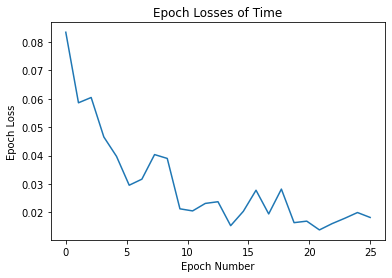

In [40]:
train_model(model, dataloader, num_epochs = 25, accumulation_steps = 4, learning_rate = 3e-4)

# Examine performance:

In [45]:
dumb = next(iter(dataloader))
dumb_recon = model(dumb)

In [46]:
print(f"Input MLP test performance:")
sampled_mlp = sample_first_mlp_from_batch(dumb)
test_mlp(sampled_mlp, test_loader)

Input MLP test performance:


92.71

In [47]:
print(f"Output MLP test performance:")
sampled_mlp = sample_first_mlp_from_batch(dumb_recon)
test_mlp(sampled_mlp, test_loader)

Output MLP test performance:


14.87

In [48]:
k = 25 #dataset.__len__()
true = []
recon = []
for i in range(k):
    dumb = next(iter(dataloader))
    dumb_recon = model(dumb)
    true.append(test_mlp(sample_first_mlp_from_batch(dumb), test_loader))
    recon.append(test_mlp(sample_first_mlp_from_batch(dumb_recon), test_loader))

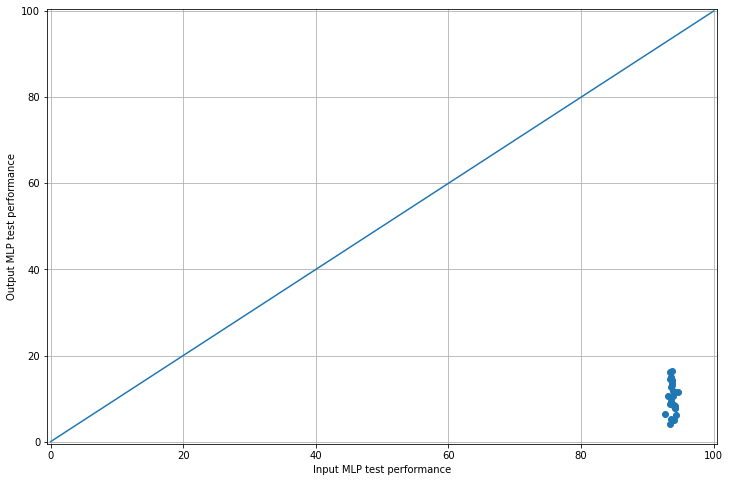

In [49]:
plt.figure(figsize=(12, 8))
plt.scatter(true, recon)
plt.plot( (0,100), (0,100) )
plt.xlim(-0.5, 100.5)
plt.ylim(-0.5, 100.5)

plt.xlabel(f"Input MLP test performance")
plt.ylabel(f"Output MLP test performance")
plt.grid()
plt.show()

# Compare fresh MLP training vs retraining generated version

In [50]:
def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

def test_mlp(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

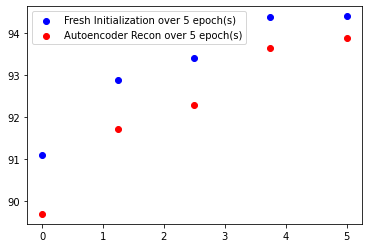

In [51]:
test_range = 5

dumb = next(iter(dataloader))
dumb_recon = model(dumb)

new_model = sample_first_mlp_from_batch(dumb_recon)
old_model = MLP(init_type='xavier', seed=np.random.randint(10))

recon_acc, org_acc = [], []

for i in range(test_range):
    train_mlp( new_model, epochs = 1 ) 
    train_mlp( old_model, epochs = 1 )
    
    org_acc.append(test_mlp(old_model, test_loader))
    recon_acc.append(test_mlp(new_model, test_loader))
    

x = np.linspace(0, test_range, test_range)
plt.scatter(x, org_acc, label = f"Fresh Initialization over {test_range} epoch(s)", color = 'b')
plt.scatter(x, recon_acc, label = f"Autoencoder Recon over {test_range} epoch(s)", color = 'r')
plt.legend()
plt.show()

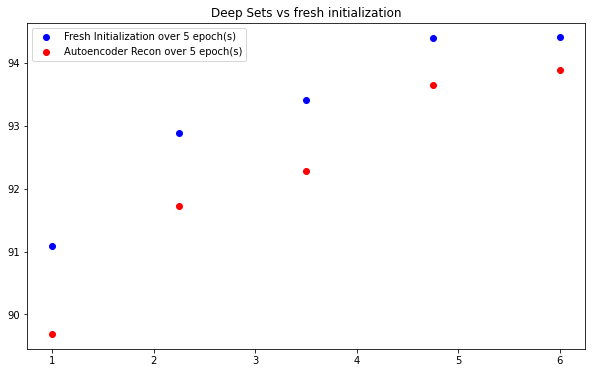

In [53]:
x = np.linspace(0, test_range, test_range)
plt.figure(figsize=(10, 6))
plt.scatter(x+1, org_acc, label = f"Fresh Initialization over {test_range} epoch(s)", color = 'b')
plt.scatter(x+1, recon_acc, label = f"Autoencoder Recon over {test_range} epoch(s)", color = 'r')
plt.title(f"Deep Sets vs fresh initialization")
plt.legend()
plt.show()

# Tuning:

In [ ]:
model = DeepSetAutoEncoder(weight_shapes, bias_shapes)
print(f"Model has: {count_parameters(model)} learnable params.")

train_model(model, dataloader, num_epochs = 25, accumulation_steps = 8, learning_rate = 1e-3)


[0 25], train loss: 0.02291, epoch loss: 0.09162, epoch time: 4.700:  20%|██        | 1/5 [00:08<00:33,  8.28s/it]

Epoch 1 sample reconstruction accuracy: 9.1


[4 25], train loss: 0.01636, epoch loss: 0.06546, epoch time: 4.535: 100%|██████████| 5/5 [00:26<00:00,  5.20s/it]


Training complete!


  0%|          | 0/5 [00:00<?, ?it/s]

Output MLP test performance: 6.5
Output MLP Loss: 0.002712698420509696
With LR: 0.0003


[0 25], train loss: 0.03873, epoch loss: 0.15494, epoch time: 4.451:  20%|██        | 1/5 [00:07<00:31,  7.98s/it]

Epoch 1 sample reconstruction accuracy: 7.0


[4 25], train loss: 0.01618, epoch loss: 0.06472, epoch time: 4.309: 100%|██████████| 5/5 [00:25<00:00,  5.11s/it]


Training complete!


  0%|          | 0/5 [00:00<?, ?it/s]

Output MLP test performance: 9.99
Output MLP Loss: 0.01009595301002264
With LR: 0.0005


[0 25], train loss: 0.08769, epoch loss: 0.35078, epoch time: 4.675:  20%|██        | 1/5 [00:08<00:33,  8.32s/it]

Epoch 1 sample reconstruction accuracy: 8.16


[4 25], train loss: 0.01686, epoch loss: 0.06745, epoch time: 4.536: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]


Training complete!


  0%|          | 0/5 [00:00<?, ?it/s]

Output MLP test performance: 10.16
Output MLP Loss: 0.010371211916208267
With LR: 0.0008


[0 25], train loss: 0.06454, epoch loss: 0.25816, epoch time: 4.540:  20%|██        | 1/5 [00:08<00:32,  8.07s/it]

Epoch 1 sample reconstruction accuracy: 12.21


[4 25], train loss: 0.01328, epoch loss: 0.05311, epoch time: 4.497: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


Training complete!


  0%|          | 0/5 [00:00<?, ?it/s]

Output MLP test performance: 10.27
Output MLP Loss: 0.007951272651553154
With LR: 0.001


[0 25], train loss: 14.81664, epoch loss: 59.26658, epoch time: 4.566:  20%|██        | 1/5 [00:08<00:32,  8.10s/it]

Epoch 1 sample reconstruction accuracy: 11.83


[4 25], train loss: 48.64807, epoch loss: 194.59229, epoch time: 4.516: 100%|██████████| 5/5 [00:26<00:00,  5.20s/it]


Training complete!


  0%|          | 0/5 [00:00<?, ?it/s]

Output MLP test performance: 9.58
Output MLP Loss: 47.397762298583984
With LR: 0.003


[0 25], train loss: 2045.45435, epoch loss: 8181.81738, epoch time: 4.641:  20%|██        | 1/5 [00:08<00:32,  8.19s/it]

Epoch 1 sample reconstruction accuracy: 14.71


[4 25], train loss: 23.12633, epoch loss: 92.50530, epoch time: 4.310: 100%|██████████| 5/5 [00:25<00:00,  5.16s/it]     


Training complete!


  0%|          | 0/5 [00:00<?, ?it/s]

Output MLP test performance: 9.7
Output MLP Loss: 135.54257202148438
With LR: 0.005


[0 25], train loss: 9119.08496, epoch loss: 36476.33984, epoch time: 4.596:  20%|██        | 1/5 [00:08<00:32,  8.15s/it]

Epoch 1 sample reconstruction accuracy: 11.66


[4 25], train loss: 32279.52734, epoch loss: 129118.10938, epoch time: 4.469: 100%|██████████| 5/5 [00:26<00:00,  5.21s/it]


Training complete!
Output MLP test performance: 3.92
Output MLP Loss: 393298.71875
With LR: 0.008


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

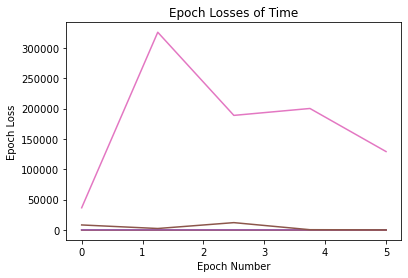

In [111]:
learning_rates = [3e-4, 5e-4, 8e-4, 1e-3, 3e-3, 5e-3, 8e-3]

criterion = TupleLoss()
depth = 5
steps = 4
tests, losses = [], []

for rate in learning_rates:
    model = DeepSetAutoEncoder(weight_shapes, bias_shapes)
    train_model(model, dataloader, num_epochs = depth, accumulation_steps = steps, learning_rate = rate)
    
    dumb = next(iter(dataloader))
    dumb_recon = model(dumb)
    
    sampled_mlp = sample_first_mlp_from_batch(dumb_recon)
    test = test_mlp(sampled_mlp, test_loader)
    tests.append(test)
    
    loss = criterion(dumb, dumb_recon)
    losses.append(loss)
    
    print(f"Output MLP test performance: {test}")
    print(f"Output MLP Loss: {loss}")
    print(f"With LR: {rate}")
    

(0.0, 0.0125)

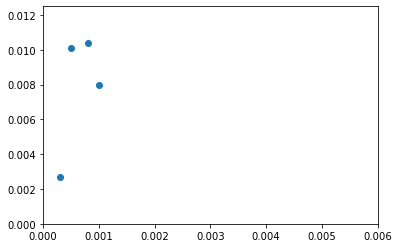

In [118]:
# for i in range(len(losses)):
#     losses[i] = losses[i].detach().numpy()

plt.scatter(learning_rates, losses)
plt.xlim(0, 6e-3)
plt.ylim(0, 0.0125)

# Compare in/out with tSNE

In [ ]:
#         model = MLP()
#         model = load_model_weights(model, model_path)
#         org_models.append(model)

